In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import soundfile as sf

from configs.params_v1 import reorder_feats
from paths import DATA_DIR

import utils_ema.ema_dataset

from scipy.stats import pearsonr
from metrics import normalized_dtw_score
from utils import plot_art_14

from tqdm import tqdm

In [2]:
from text.converters import arpabet2ipa
from utils_dataset.mspka import mspka2ipa
from utils_dataset.pb2007 import pb20072ipa
from utils_dataset.mngu0 import mngu02ipa

lj_ipa_set = set(arpabet2ipa.values())

mspka_ipa = set(mspka2ipa.values())
extra_mspka_ipa = mspka_ipa - lj_ipa_set

pb2007_ipa = set(pb20072ipa.values())
extra_pb_ipa = pb2007_ipa - lj_ipa_set

mngu0_ipa = set(mngu02ipa.values())
extra_mngu0_ipa = mngu0_ipa - lj_ipa_set

dataset = "mocha_timit"
speakers = ["fsew0", "faet0", "ffes0", "maps0", "mjjn0", "msak0"]
mocha_ipa = []

version = "v1_1"
ckpt_name = "grad_3000"
for speaker in speakers:
    analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
    phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
    spk_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

    for i, row in spk_df.iterrows():
        sample_id = row["filestem"]
        phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
        for start, end, phnm in phnm3:
            if phnm not in mocha_ipa:
                mocha_ipa.append(phnm)
                
mocha_ipa = set(mocha_ipa)
extra_mocha_ipa = mocha_ipa - lj_ipa_set

dataset_2_extra_ipa = {
    "MSPKA_EMA_ita": extra_mspka_ipa,
    "pb2007": extra_pb_ipa,
    "MNGU0": extra_mngu0_ipa,
    "mocha_timit": extra_mocha_ipa,
}

In [3]:
versions_grads = {"v1" : ["grad_200", "grad_1000", "grad_2000", "grad_3000", "grad_4000", "grad_5000"],
                  "v1_1": ["grad_200", "grad_1000", "grad_2000", "grad_3000", "grad_4000", "grad_5000"],
                  "v1_" : ["grad_4750"],
                  "v2": ["grad_200", "grad_1000", "grad_2000", "grad_3000", "grad_4000"],
                  "v3": ["grad_200", "grad_1000", "grad_2000", "grad_3000", "grad_4000"],
                  "v4": ["grad_200", "grad_1000", "grad_2000", "grad_3000", "grad_4000", "grad_5000"],
                  "v2_phnmtext": ["grad_1000", "grad_2000"],
                  "v4_phnmtext": ["grad_1000", "grad_2000"],
                  "v5": ["grad_1000", "grad_2000", "grad_3000"],
                  "v5_preblock": ["grad_1000", "grad_2000", "grad_3000", "grad_4000", "grad_5000"]
                  }

score_cols = ['pcc_no_dtw', 'dtw_gt_enc', 'dtw_gt_dec', 'dtw_gt_sparc', 'dtw_sparc_enc', 'dtw_sparc_dec',
              'pcc_gt_enc', 'pcc_gt_dec', 'pcc_gt_sparc', 'pcc_sparc_enc', 'pcc_sparc_dec',
              'pred_rel_gap', 'enc_dtw_distortion', 'dec_dtw_distortion', 'sparc_dtw_distortion']

In [26]:
import utils_ema.ema_dataset

dataset = "pb2007"
processed_data_dir = DATA_DIR / dataset / "processed_data"
spkmetadata_filename = "1.0_speaker_metadata_100Hz.joblib"
# get the PCC scores of SPARC and other metadata for each sentence
spkmeta = joblib.load(processed_data_dir / f"spk1/{spkmetadata_filename}")
ids = spkmeta.list_valid_ids()
pcc_scores = []
filestems = []
splits = []
durations = []
for id in ids:
    sentencemeta = spkmeta.sentence_info[id]
    filestems.append(sentencemeta.filestem)
    splits.append(sentencemeta.split)
    pcc_scores.append(sentencemeta.PCC_score)
    durations.append(sentencemeta.duration)

summary_df = pd.DataFrame({
                            "filestem": filestems,
                            "split": splits,
                            "pcc": pcc_scores,
                            "duration": durations
                        })
if dataset == "pb2007":
    sentence_types = [spkmeta.sentence_info[id].sentence_type for id in ids]
    summary_df["sentence_types"] = sentence_types

sentence_filestems = list(summary_df[summary_df["sentence_types"] == "sentence"]["filestem"])

def get_specific_summary(dataset, speaker, version, ckpt_name, do_extra_ipa=False, remove_invalid=True):
    analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
    short_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")
    if dataset == "pb2007":
        short_df = short_df[short_df["filestem"].isin(sentence_filestems)]
    #add count of extra ipa phnms that were absent during the train
    if do_extra_ipa:
        extra_ipa = dataset_2_extra_ipa[dataset]
        phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
        short_df["extra_ipa"] = 0

        for i, row in short_df.iterrows():
            sample_id = row["filestem"]
            phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
            for start, end, phnm in phnm3:
                if phnm in extra_ipa:
                    short_df.loc[i, "extra_ipa"] += 1
    if remove_invalid:
        original_len = len(short_df)
        if 'valid_enc' in short_df.columns:
            short_df = short_df[short_df["valid_enc"]]
        if 'valid_dec' in short_df.columns:
            short_df = short_df[short_df["valid_dec"]]
            #print(f"Removed {original_len - len(short_df)} invalid samples for {dataset} {speaker} {version} {ckpt_name}")
    return short_df

def create_dataset_summary(dataset, speakers, versions):
    dataset_summary = []
    for speaker in speakers:
        analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
        for version in versions:
            ckpt_names = versions_grads[version]
            for ckpt_name in ckpt_names:
                row = {
                    "speaker": speaker,
                    "version": version,
                    "ckpt_name": ckpt_name
                }
                #short_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")
                short_df = get_specific_summary(dataset, speaker, version, ckpt_name, do_extra_ipa=False)
                row["speaker"] = speaker
                row["version"] = version
                row["ckpt_name"] = ckpt_name
                short_means = short_df.describe().loc["mean"]
                for colname, v in zip(short_means.keys(), short_means.values):
                    row[colname] = v
                dataset_summary.append(row)

    dataset_summary = pd.DataFrame(dataset_summary)
    dataset_summary.rename(columns={"ckpt_name" : "epoch"}, inplace=True)
    dataset_summary["epoch"] = dataset_summary["epoch"].str.replace("grad_", "").astype(int)
    dataset_summary.drop(columns=["pcc", "duration"], inplace=True)
    return dataset_summary

def plot_speaker_scores(speaker, dataset, versions, dataset_summary, ref="gt", show_enc=False):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax = ax.flatten()
    spk_summary = dataset_summary[dataset_summary["speaker"] == speaker]
    for i, version in enumerate(versions):
        version_summary = spk_summary[spk_summary["version"] == version]
        version_summary = version_summary.sort_values(by="epoch")
        if show_enc:
            ax[0].plot(version_summary["epoch"], version_summary[f"pcc_{ref}_enc"],marker="v", c=colors[i], linestyle="--")
        ax[0].plot(version_summary["epoch"], version_summary[f"pcc_{ref}_dec"],marker="o", c=colors[i], linestyle="-", label=f"{version} dec")
        ax[0].set_xlabel("Checkpoint Name")
        ax[0].set_ylabel("PCC")
        ax[0].set_title(f"Speaker {speaker} - {dataset}")
        ax[0].legend()
        ax[0].grid()
    ax[0].grid()
    
    for i, version in enumerate(versions):
        version_summary = spk_summary[spk_summary["version"] == version]
        version_summary = version_summary.sort_values(by="epoch")
        if show_enc:
            ax[1].plot(version_summary["epoch"], version_summary[f"dtw_{ref}_enc"],marker="v", c=colors[i], linestyle="--")
        ax[1].plot(version_summary["epoch"], version_summary[f"dtw_{ref}_dec"],marker="o", c=colors[i], linestyle="-", label=f"{version} dec")
        ax[1].set_xlabel("Checkpoint Name")
        ax[1].set_ylabel("DTW")
        ax[1].set_title(f"Speaker {speaker} - {dataset}")
        ax[1].legend()
        ax[1].grid()
    ax[1].grid()
    plt.tight_layout()
    

Quantitative evaluation of the arttts generated samples from the SPARC-extracted EMA features with the best and worst PCC score (Careful, may be influenced by the quality ofthe linear transfo. The PCC scores are computed on linearly transformed features (from MNGU0 space to concerned speaker) while the reconstruction takes an MNGU0-space input)

We want to assess how powerful the HiFi GAN is and how much it relies on accurate EMA/articulatory predictions.

We also test the sensitivity to pitch and speaker embedding

# MSPKA_EMA_ita

In [5]:
dataset = "MSPKA_EMA_ita"
speakers = ["cnz", "lls", "olm"]
versions = ["v2", "v2_phnmtext", "v3"]
dataset_summary = create_dataset_summary(dataset, speakers, versions)
dataset_summary.head()

,speaker,version,epoch,pcc_no_dtw,dtw_gt_enc,dtw_gt_dec,dtw_gt_sparc,dtw_sparc_enc,dtw_sparc_dec,pcc_gt_enc,pcc_gt_dec,pcc_gt_sparc,pcc_sparc_enc,pcc_sparc_dec,pred_rel_gap,enc_dtw_distortion,dec_dtw_distortion,sparc_dtw_distortion
0,cnz,v2,200,0.773684,8.438777,8.609616,6.680188,6.657872,7.253157,0.684910,0.654648,0.769607,0.658435,0.604724,0.100345,0.685452,0.628221,0.460804
1,cnz,v2,1000,0.773684,8.492590,8.771671,6.680188,6.783210,7.261780,0.682821,0.650775,0.769607,0.651881,0.607115,0.101203,0.662582,0.658865,0.460804
2,cnz,v2,2000,0.773684,8.503389,8.828529,6.680188,6.856503,7.307769,0.678757,0.645355,0.769607,0.645415,0.601895,0.100606,0.643006,0.663080,0.460804
3,cnz,v2,3000,0.773684,8.502062,8.759049,6.680188,6.895710,7.327135,0.679983,0.649727,0.769607,0.643581,0.605266,0.102697,0.624340,0.625311,0.460804
4,cnz,v2,4000,0.773684,8.537550,8.702398,6.680188,6.912580,7.291248,0.674574,0.652296,0.769607,0.639046,0.604543,0.103003,0.631656,0.609126,0.460804


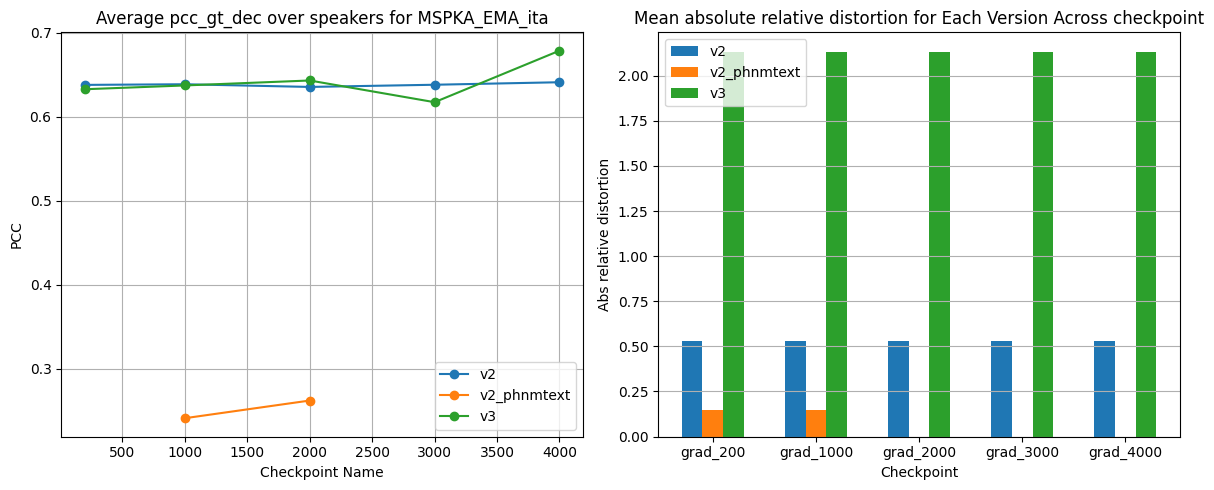

In [6]:
versions = ["v2", "v2_phnmtext", "v3"]
#versions = ["v1_1", "v2", "v4", "v2_phnmtext", "v4_phnmtext"]
dataset_summary = create_dataset_summary(dataset, speakers, versions)
avg_summary = dataset_summary.groupby(["version", "epoch"]).mean(score_cols).reset_index() #average over speakers
avg_summary = avg_summary[["version", "epoch"] + score_cols]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
col = "pcc_gt_dec"
for version in versions:
    ax[0].plot(avg_summary[avg_summary["version"] == version]["epoch"],
             avg_summary[avg_summary["version"] == version][col],
             marker="o", label=version)
ax[0].set_xlabel("Checkpoint Name")
ax[0].set_ylabel("PCC")
ax[0].set_title(f"Average {col} over speakers for {dataset}")
ax[0].grid()
ax[0].legend()

#plotting mean absolute relative distortion by dtw
width = 0.2  # Bar width
#x = np.arange(len(datasets))  # Dataset positions
mean_scores = []
xs = []
for version in versions:
    means = []
    stds = []
    version_df = avg_summary[avg_summary["version"] == version]
    ckpts = versions_grads[version]
    xs.append(ckpts)
    for ckpt in ckpts:
        means.append(version_df["dec_dtw_distortion"].mean())
    mean_scores.append(means)

for i, version in enumerate(versions):
    x = np.arange(len(xs[i]))  # Update x positions for each version
    ax[1].bar(x + i * width, mean_scores[i], width, label=version, capsize=5)

# Add labels and legend
ax[1].set_xlabel("Checkpoint")
ax[1].set_ylabel("Abs relative distortion")
ax[1].set_title("Mean absolute relative distortion for Each Version Across checkpoint")
ax[1].set_xticks(np.arange(len(xs[0])) + width)
ax[1].set_xticklabels(xs[0])
ax[1].legend()
ax[1].grid(axis="y")

plt.tight_layout()
plt.show()

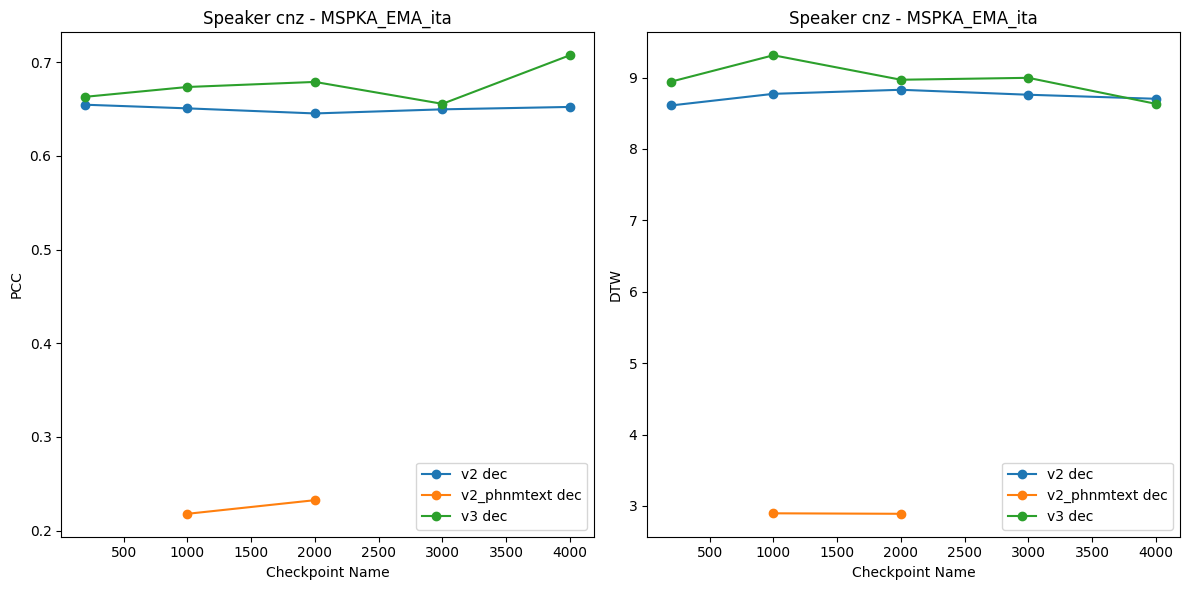

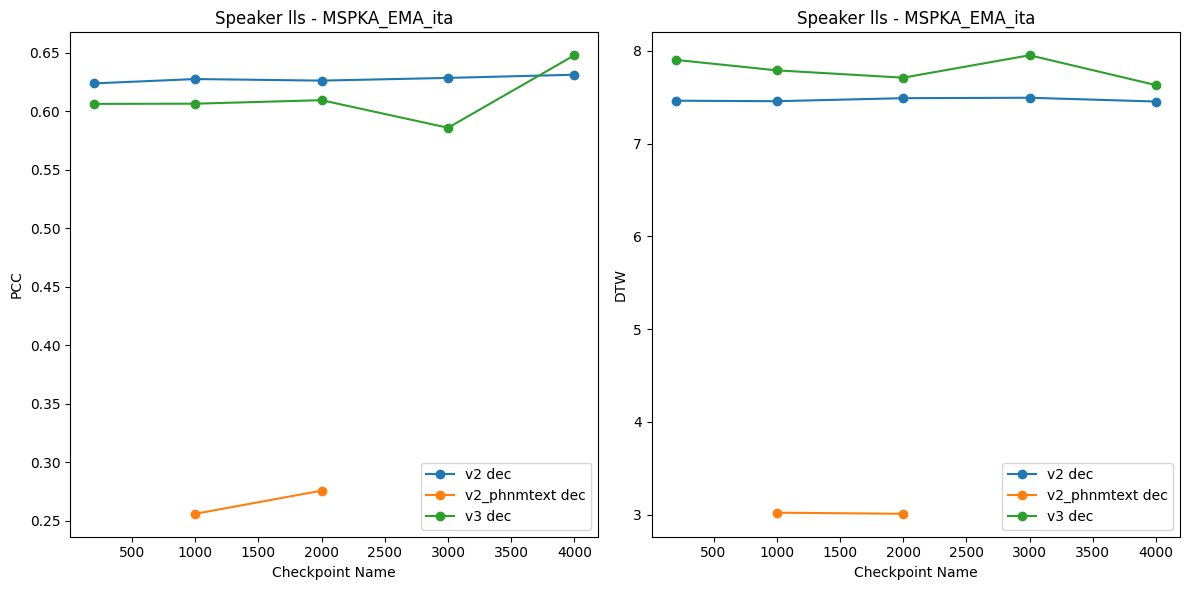

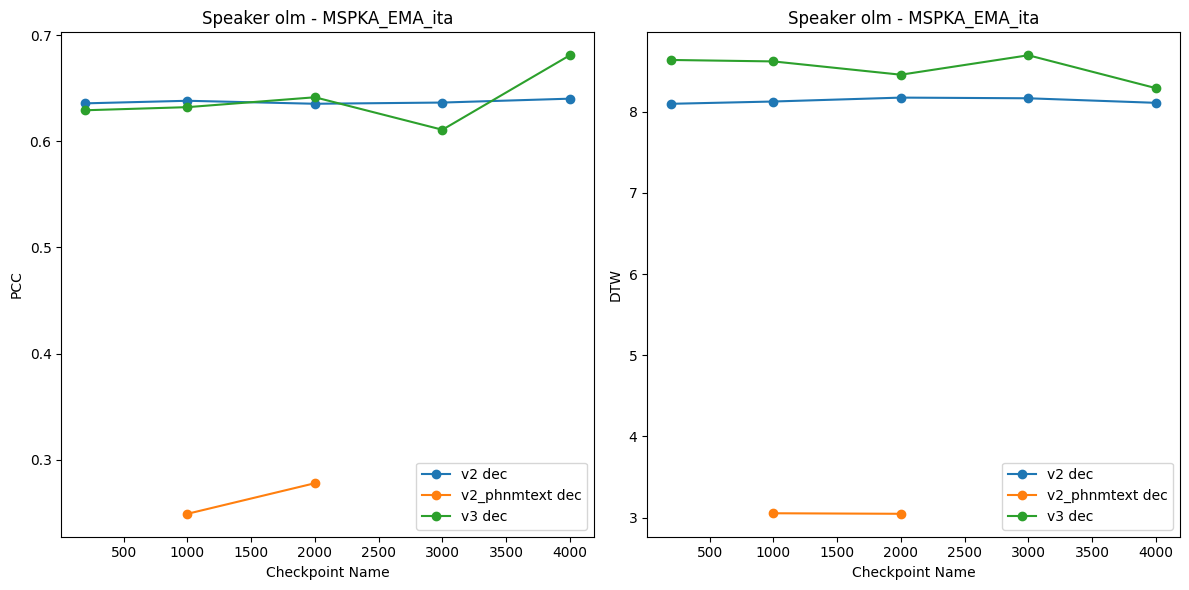

In [7]:
versions = ["v2", "v2_phnmtext", "v3"]

plot_speaker_scores("cnz", dataset, versions, dataset_summary, ref="gt")
plot_speaker_scores("lls", dataset, versions, dataset_summary, ref="gt")
plot_speaker_scores("olm", dataset, versions, dataset_summary, ref="gt")

/tmp/ipykernel_13648/2833341393.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["pcc_gt_dec"].values for df in versions_dfs],


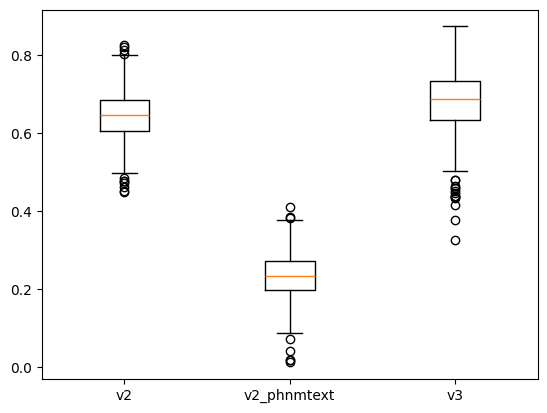

In [8]:
ckpt_name = "grad_2000"
versions = ["v2", "v2_phnmtext", "v3"]
speaker = "cnz"
versions_dfs = []

for version in versions:
    versions_dfs.append(get_specific_summary(dataset, speaker, version, ckpt_name))

plt.boxplot([df["pcc_gt_dec"].values for df in versions_dfs],
             labels=versions);

/tmp/ipykernel_13648/305333982.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["pcc_gt_dec"].values for df in ckpt_names_dfs],


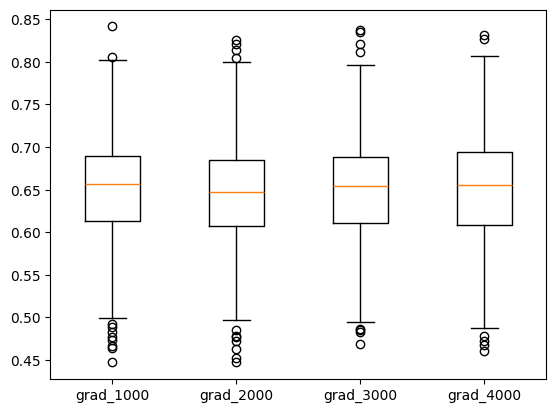

In [9]:
ckpt_names = ["grad_1000", "grad_2000", "grad_3000", "grad_4000"]
#ckpt_names = ["grad_1000", "grad_2000", "grad_3000"]
#versions = ["v1_1", "v5", "v5_preblock"]
version = "v2"
#version = "v5_preblock"
speaker = "cnz"
ckpt_names_dfs = []

for ckpt_name in ckpt_names:
    ckpt_names_dfs.append(get_specific_summary(dataset, speaker, version, ckpt_name))

plt.boxplot([df["pcc_gt_dec"].values for df in ckpt_names_dfs],
             labels=ckpt_names);

# mocha_timit

In [27]:
dataset = "mocha_timit"
speakers = ["faet0", "fsew0", "ffes0", "maps0", "msak0", "mjjn0"]
versions = ["v2", "v2_phnmtext", "v3"]
dataset_summary = create_dataset_summary(dataset, speakers, versions)
dataset_summary.head()

,speaker,version,epoch,pcc_no_dtw,dtw_gt_enc,dtw_gt_dec,dtw_gt_sparc,dtw_sparc_enc,dtw_sparc_dec,pcc_gt_enc,pcc_gt_dec,pcc_gt_sparc,pcc_sparc_enc,pcc_sparc_dec,pred_rel_gap,enc_dtw_distortion,dec_dtw_distortion,sparc_dtw_distortion
0,faet0,v2,200,0.696867,5.939343,6.567351,4.190765,6.485484,7.086086,0.744577,0.695675,0.822549,0.674977,0.630819,0.214537,0.516876,0.535570,0.13803
1,faet0,v2,1000,0.696867,6.024525,6.538673,4.190765,6.564463,7.022851,0.737633,0.695028,0.822549,0.671809,0.630602,0.201111,0.510758,0.507819,0.13803
2,faet0,v2,2000,0.696867,6.134097,6.594966,4.190765,6.670985,7.091779,0.728298,0.684458,0.822549,0.666784,0.623543,0.197734,0.509962,0.502588,0.13803
3,faet0,v2,3000,0.696867,6.169718,6.620227,4.190765,6.701800,7.129464,0.725709,0.688200,0.822549,0.664343,0.626298,0.193407,0.506139,0.503747,0.13803
4,faet0,v2,4000,0.696867,6.190877,6.581919,4.190765,6.744809,7.105986,0.724798,0.692432,0.822549,0.659082,0.631884,0.202778,0.516599,0.519218,0.13803


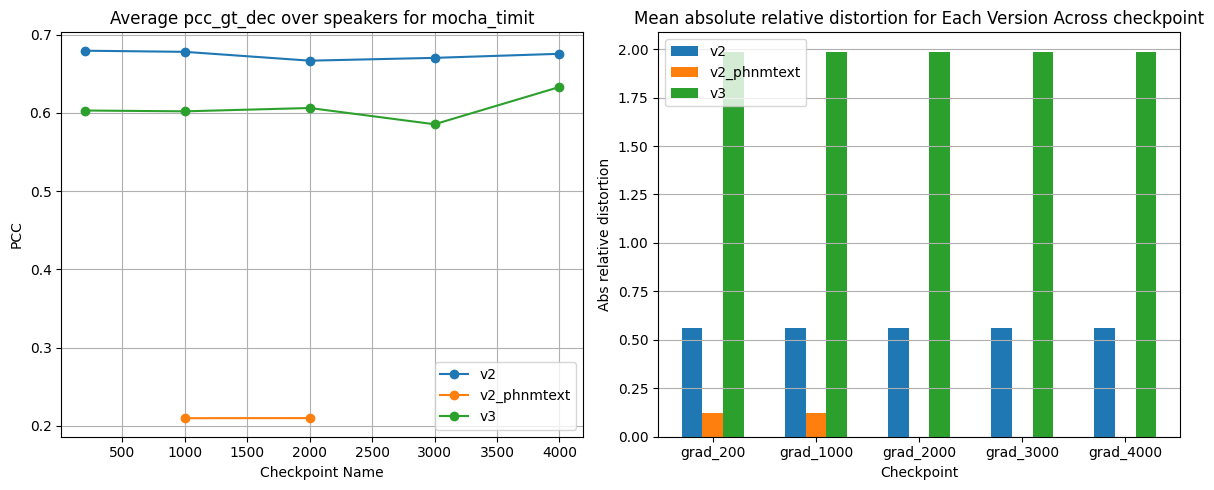

In [ ]:
versions = ["v2", "v2_phnmtext", "v3"]
#versions = ["v1_1", "v2", "v4", "v2_phnmtext", "v4_phnmtext"]
dataset_summary = create_dataset_summary(dataset, speakers, versions)
avg_summary = dataset_summary.groupby(["version", "epoch"]).mean(score_cols).reset_index() #average over speakers
avg_summary = avg_summary[["version", "epoch"] + score_cols]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
col = "pcc_gt_dec"
for version in versions:
    ax[0].plot(avg_summary[avg_summary["version"] == version]["epoch"],
             avg_summary[avg_summary["version"] == version][col],
             marker="o", label=version)
ax[0].set_xlabel("Checkpoint Name")
ax[0].set_ylabel("PCC")
ax[0].set_title(f"Average {col} over speakers for {dataset}")
ax[0].grid()
ax[0].legend()

#plotting mean absolute relative distortion by dtw
width = 0.2  # Bar width
#x = np.arange(len(datasets))  # Dataset positions
mean_scores = []
xs = []
for version in versions:
    means = []
    stds = []
    version_df = avg_summary[avg_summary["version"] == version]
    ckpts = versions_grads[version]
    xs.append(ckpts)
    for ckpt in ckpts:
        means.append(version_df["dec_dtw_distortion"].mean())
    mean_scores.append(means)

for i, version in enumerate(versions):
    x = np.arange(len(xs[i]))  # Update x positions for each version
    ax[1].bar(x + i * width, mean_scores[i], width, label=version, capsize=5)

# Add labels and legend
ax[1].set_xlabel("Checkpoint")
ax[1].set_ylabel("Abs relative distortion")
ax[1].set_title("Mean absolute relative distortion for Each Version Across checkpoint")
ax[1].set_xticks(np.arange(len(xs[0])) + width)
ax[1].set_xticklabels(xs[0])
ax[1].legend()
ax[1].grid(axis="y")

plt.tight_layout()
plt.show()

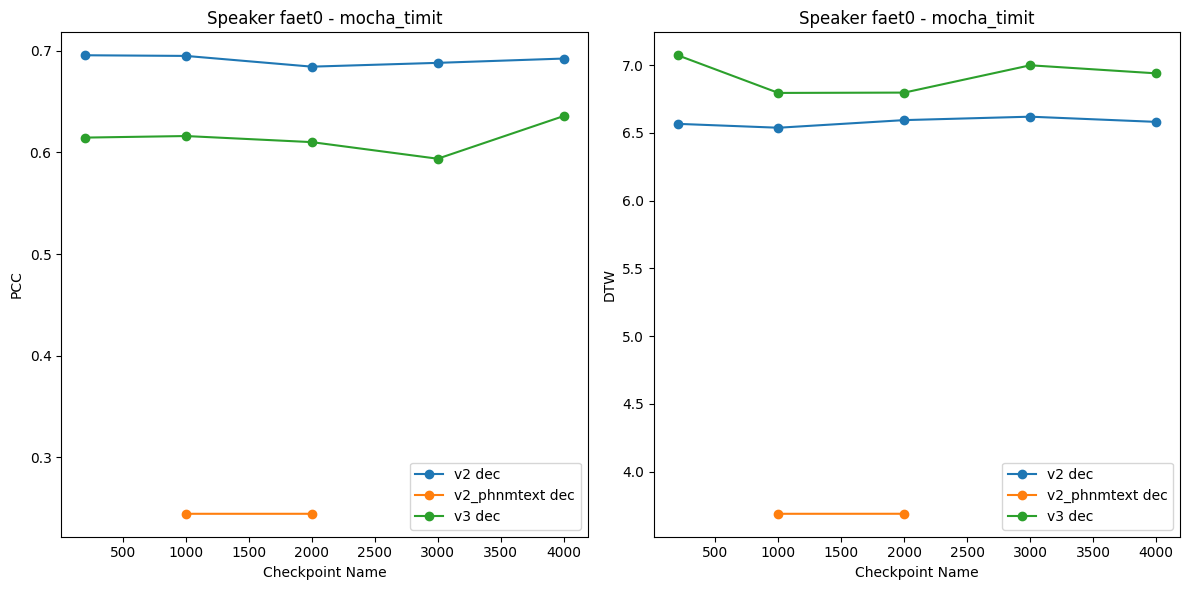

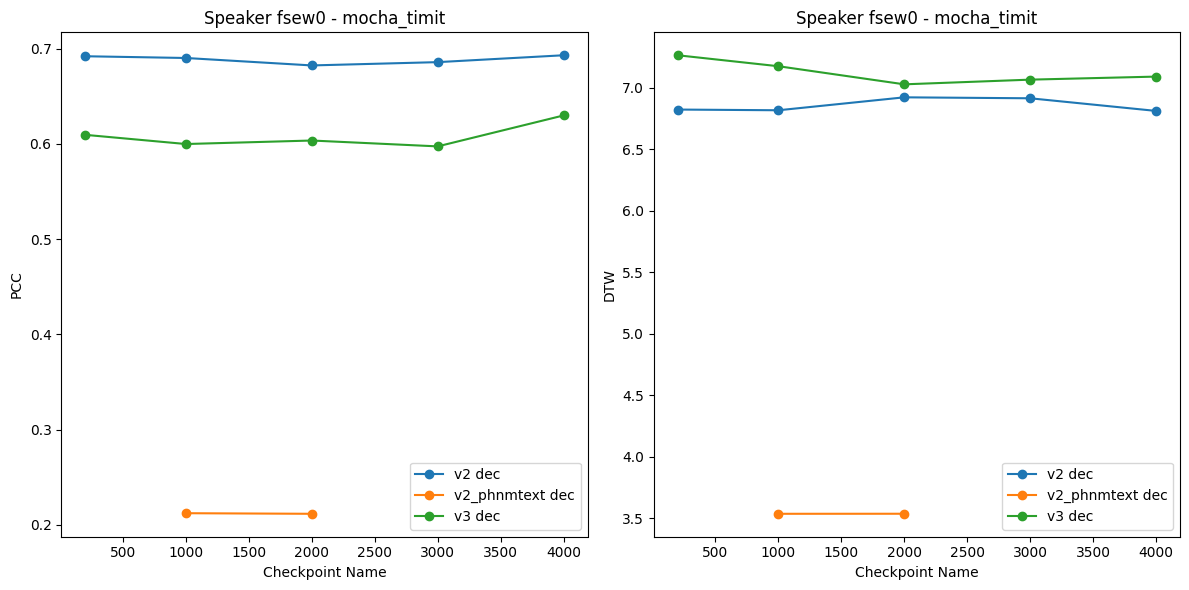

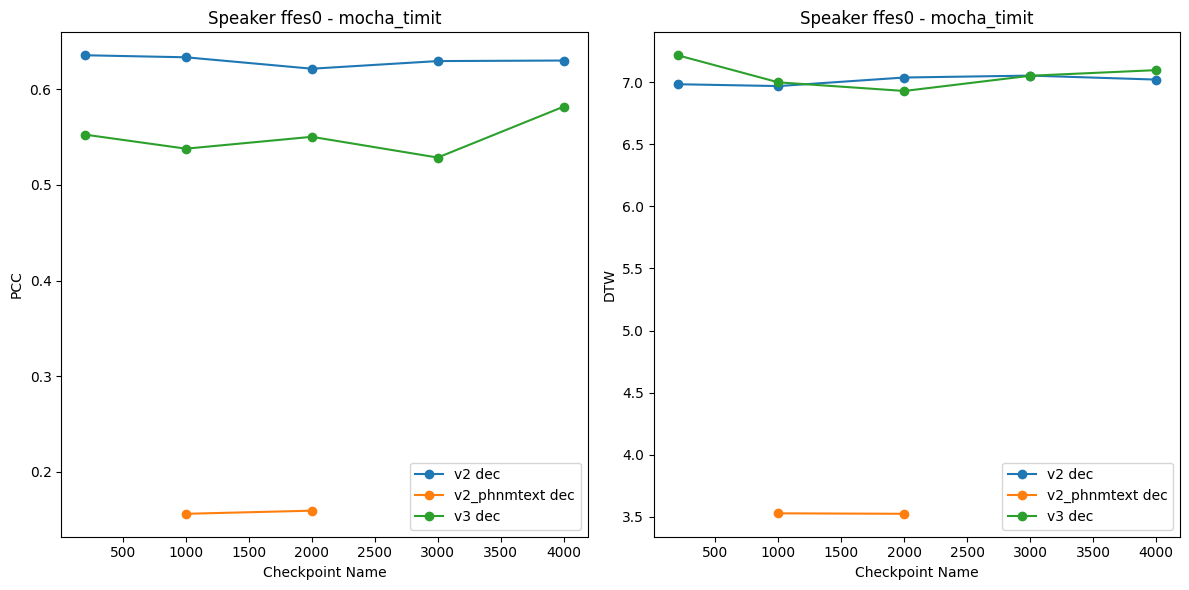

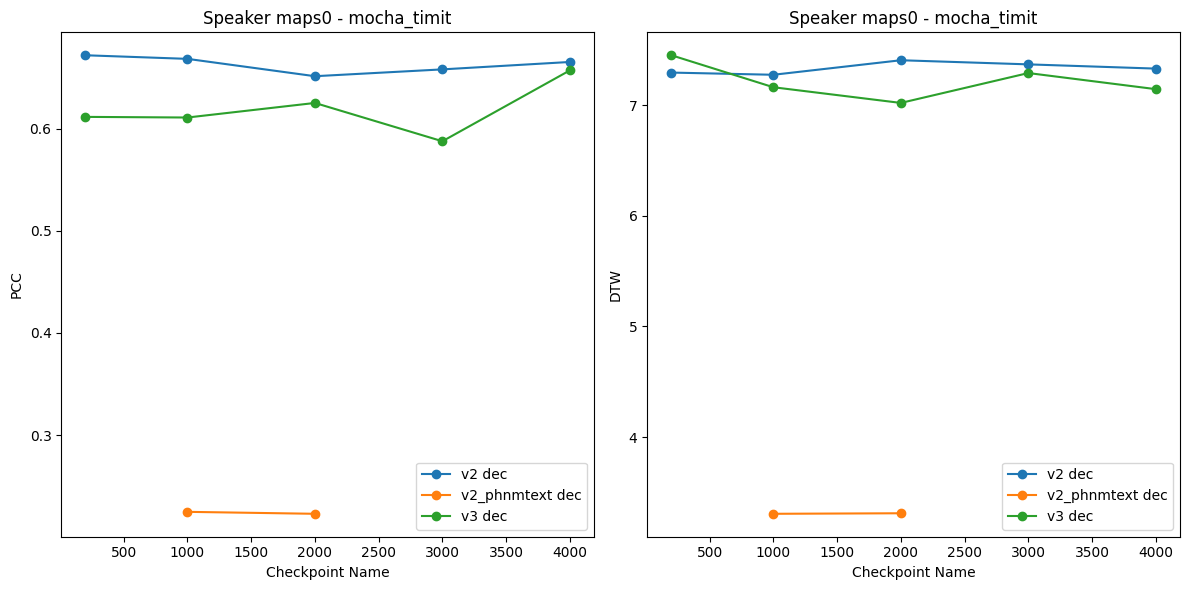

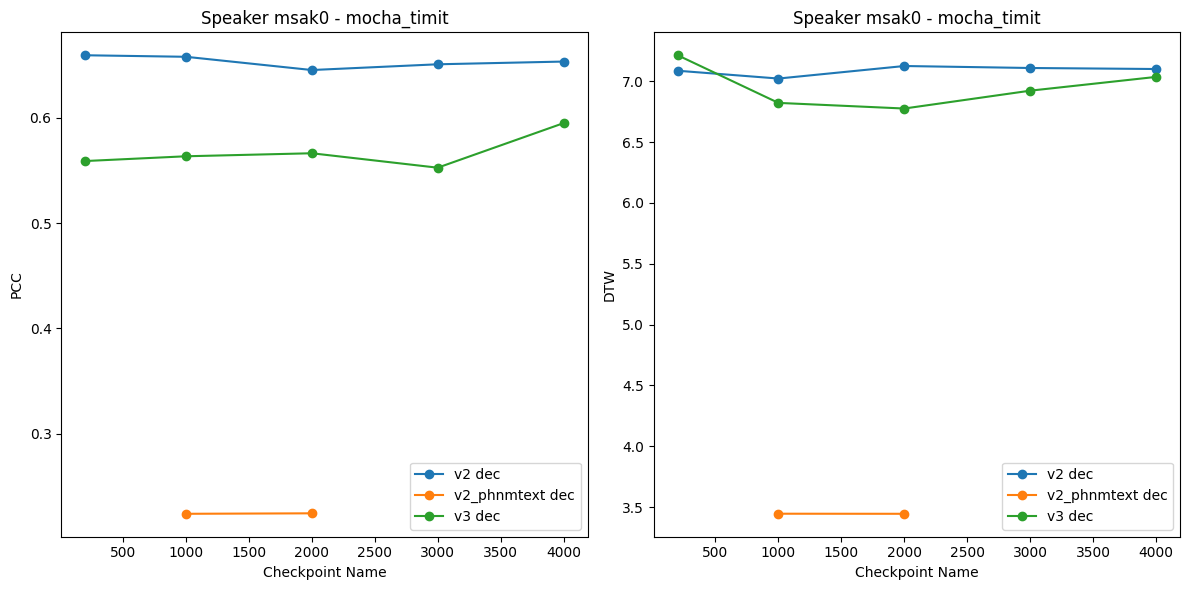

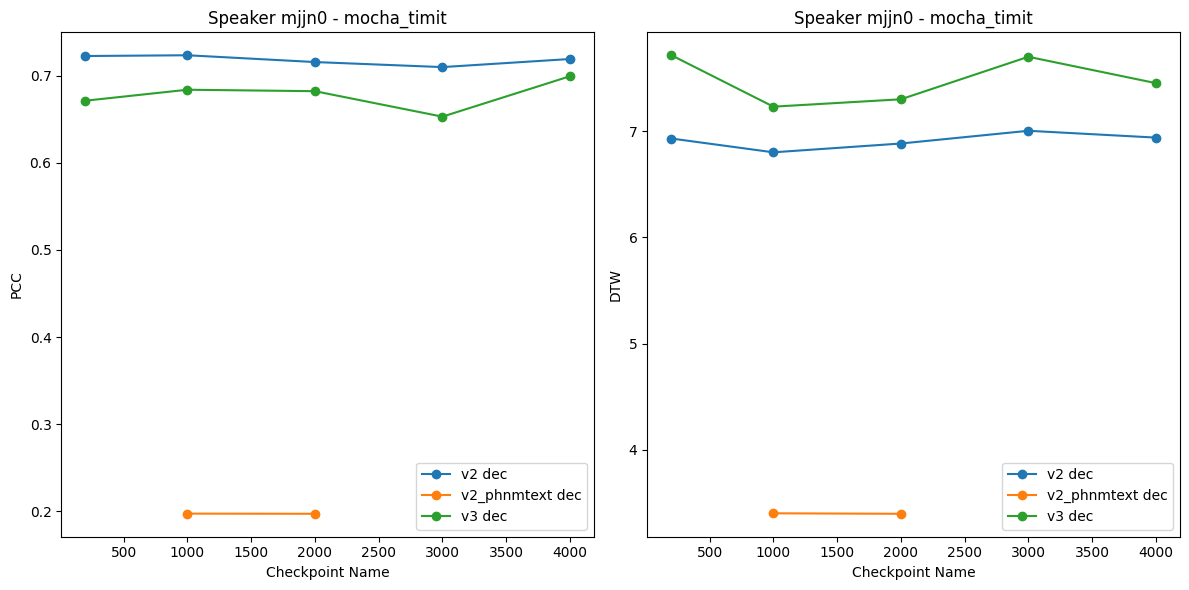

In [12]:
versions = ["v2", "v2_phnmtext", "v3"]

for spk in speakers:
    plot_speaker_scores(spk, dataset, versions, dataset_summary, ref="gt")

/tmp/ipykernel_13648/3555309671.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["pcc_gt_dec"].values for df in versions_dfs],


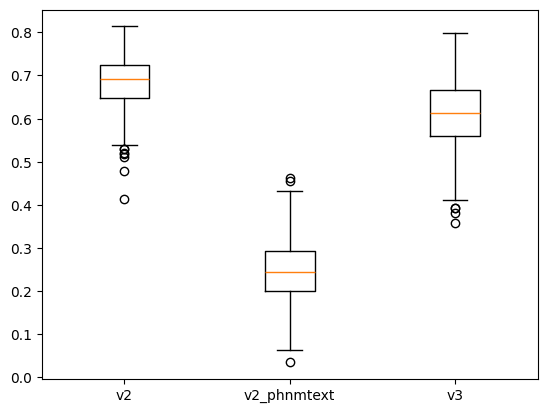

In [13]:
ckpt_name = "grad_2000"
versions = ["v2", "v2_phnmtext", "v3"]
speaker = "faet0"
versions_dfs = []

for version in versions:
    versions_dfs.append(get_specific_summary(dataset, speaker, version, ckpt_name))

plt.boxplot([df["pcc_gt_dec"].values for df in versions_dfs],
             labels=versions);

/tmp/ipykernel_13648/4169230329.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["pcc_gt_dec"].values for df in ckpt_names_dfs],


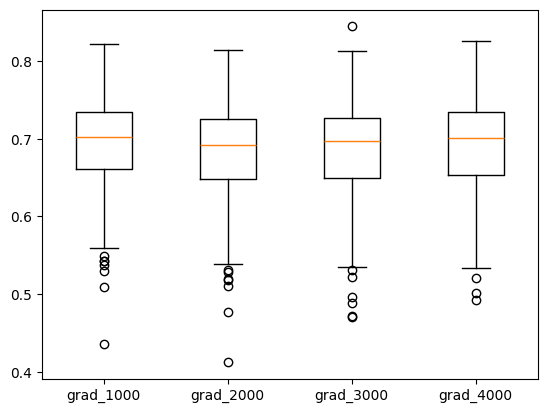

In [14]:
ckpt_names = ["grad_1000", "grad_2000", "grad_3000", "grad_4000"]
#ckpt_names = ["grad_1000", "grad_2000", "grad_3000"]
#versions = ["v1_1", "v5", "v5_preblock"]
version = "v2"
#version = "v5_preblock"
speaker = "faet0"
ckpt_names_dfs = []

for ckpt_name in ckpt_names:
    ckpt_names_dfs.append(get_specific_summary(dataset, speaker, version, ckpt_name))

plt.boxplot([df["pcc_gt_dec"].values for df in ckpt_names_dfs],
             labels=ckpt_names);

In [36]:
v2_extra_df = get_specific_summary("mocha_timit", "faet0", "v2", "grad_2000", do_extra_ipa=True)
v2_phnmtext_extra_df = get_specific_summary("mocha_timit", "faet0", "v2_phnmtext", "grad_2000", do_extra_ipa=True)

In [37]:
v2_extra_df = v2_extra_df[v2_extra_df["duration"] >= 4]
v2_phnmtext_extra_df = v2_phnmtext_extra_df[v2_phnmtext_extra_df["duration"] >= 4]

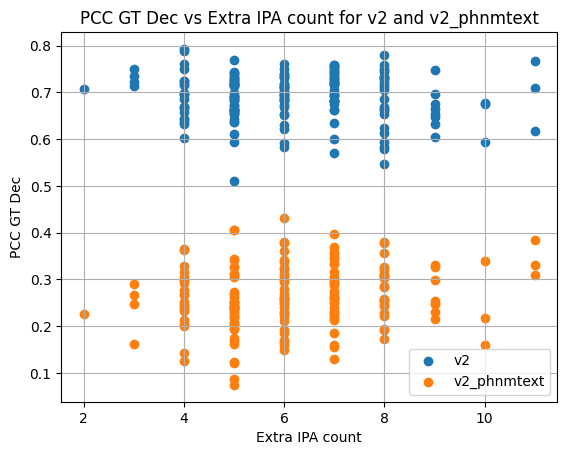

In [42]:
plt.scatter(v2_extra_df["extra_ipa"], v2_extra_df["pcc_gt_dec"], marker="o", label="v2")
plt.scatter(v2_phnmtext_extra_df["extra_ipa"], v2_phnmtext_extra_df["pcc_gt_dec"], marker="o", label="v2_phnmtext")
plt.xlabel("Extra IPA count")
plt.ylabel("PCC GT Dec")
plt.title("PCC GT Dec vs Extra IPA count for v2 and v2_phnmtext")
plt.legend()
plt.grid()

# MNGU0

In [15]:
dataset = "MNGU0"
speakers = ["s1"]
versions = ["v1", "v1_1", "v1_", "v2", "v4", "v2_phnmtext", "v4_phnmtext", "v5", "v5_preblock"]
dataset_summary = create_dataset_summary(dataset, speakers, versions)
dataset_summary.head()

,speaker,version,epoch,pcc_no_dtw,dtw_gt_enc,dtw_gt_dec,dtw_gt_sparc,dtw_sparc_enc,dtw_sparc_dec,pcc_gt_enc,pcc_gt_dec,pcc_gt_sparc,pcc_sparc_enc,pcc_sparc_dec,pred_rel_gap,enc_dtw_distortion,dec_dtw_distortion,sparc_dtw_distortion
0,s1,v1,200,0.854605,2.550461,2.750706,1.772634,2.232645,2.413423,0.764562,0.761317,0.874679,0.803046,0.802378,0.158960,0.361744,0.371393,0.083072
1,s1,v1,1000,0.854605,2.567823,2.620048,1.772634,2.250609,2.250678,0.763146,0.771524,0.874679,0.801437,0.816951,0.153076,0.351960,0.366175,0.083072
2,s1,v1,2000,0.854605,2.571979,2.572175,1.772634,2.251081,2.197259,0.763456,0.776534,0.874679,0.802354,0.822339,0.151655,0.349056,0.362462,0.083072
3,s1,v1,3000,0.854605,2.579332,2.582614,1.772634,2.263969,2.208045,0.763486,0.776444,0.874679,0.800640,0.821878,0.156943,0.355783,0.370631,0.083072
4,s1,v1,4000,0.854605,2.581140,2.578950,1.772634,2.266069,2.210204,0.761425,0.774602,0.874679,0.798141,0.819382,0.159972,0.358861,0.374388,0.083072


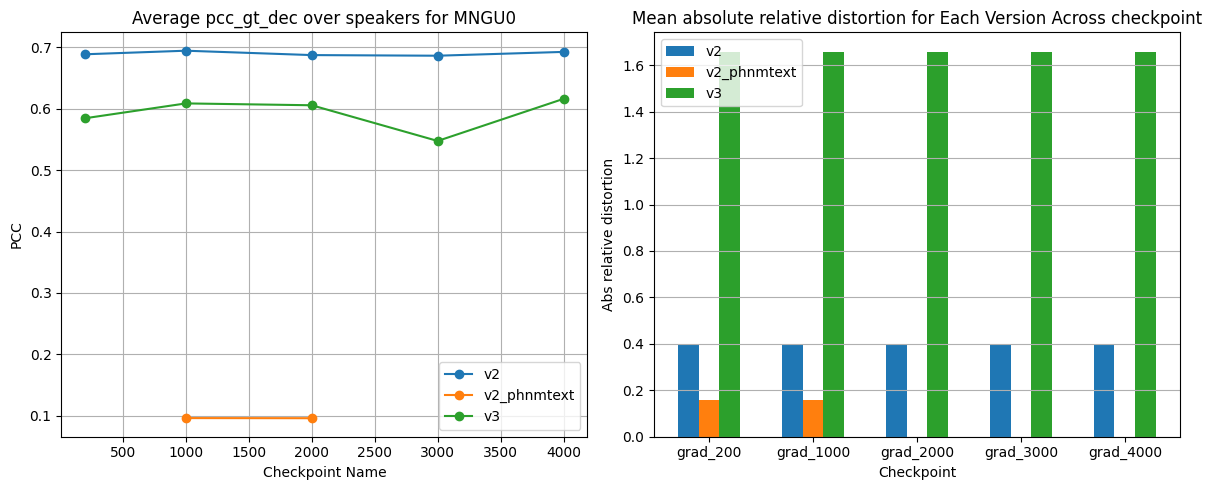

In [16]:
versions = ["v2", "v2_phnmtext", "v3"]
#versions = ["v1_1", "v2", "v4", "v2_phnmtext", "v4_phnmtext"]
dataset_summary = create_dataset_summary(dataset, speakers, versions)
avg_summary = dataset_summary.groupby(["version", "epoch"]).mean(score_cols).reset_index() #average over speakers
avg_summary = avg_summary[["version", "epoch"] + score_cols]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
col = "pcc_gt_dec"
for version in versions:
    ax[0].plot(avg_summary[avg_summary["version"] == version]["epoch"],
             avg_summary[avg_summary["version"] == version][col],
             marker="o", label=version)
ax[0].set_xlabel("Checkpoint Name")
ax[0].set_ylabel("PCC")
ax[0].set_title(f"Average {col} over speakers for {dataset}")
ax[0].grid()
ax[0].legend()

#plotting mean absolute relative distortion by dtw
width = 0.2  # Bar width
#x = np.arange(len(datasets))  # Dataset positions
mean_scores = []
xs = []
for version in versions:
    means = []
    stds = []
    version_df = avg_summary[avg_summary["version"] == version]
    ckpts = versions_grads[version]
    xs.append(ckpts)
    for ckpt in ckpts:
        means.append(version_df["dec_dtw_distortion"].mean())
    mean_scores.append(means)

for i, version in enumerate(versions):
    x = np.arange(len(xs[i]))  # Update x positions for each version
    ax[1].bar(x + i * width, mean_scores[i], width, label=version, capsize=5)

# Add labels and legend
ax[1].set_xlabel("Checkpoint")
ax[1].set_ylabel("Abs relative distortion")
ax[1].set_title("Mean absolute relative distortion for Each Version Across checkpoint")
ax[1].set_xticks(np.arange(len(xs[0])) + width)
ax[1].set_xticklabels(xs[0])
ax[1].legend()
ax[1].grid(axis="y")

plt.tight_layout()
plt.show()

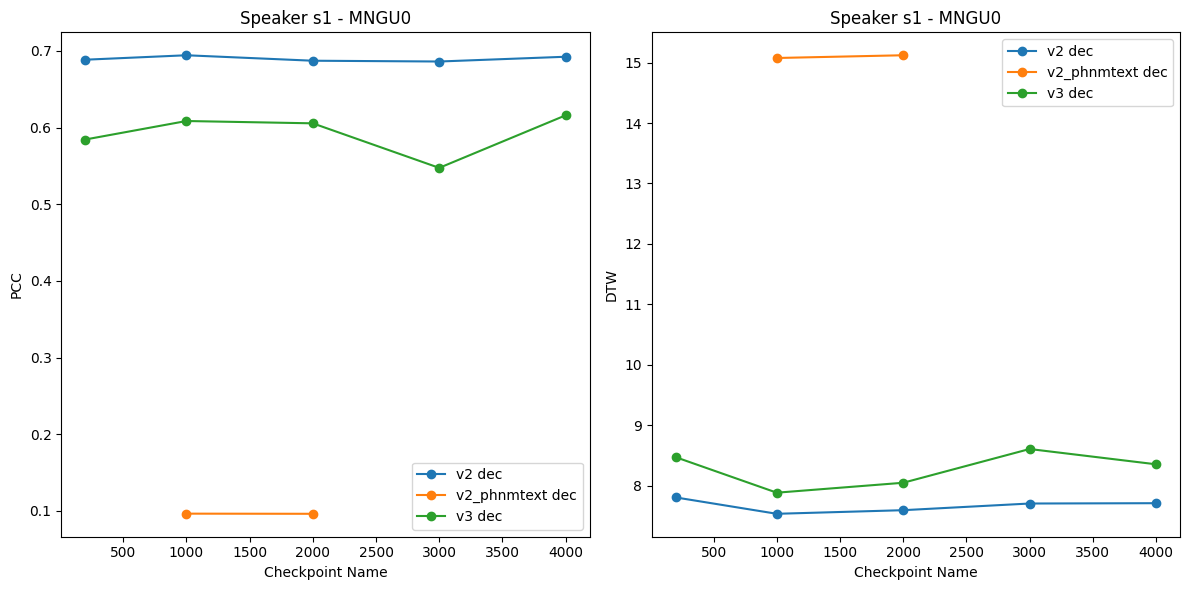

In [17]:
versions = ["v2", "v2_phnmtext", "v3"]

for spk in speakers:
    plot_speaker_scores(spk, dataset, versions, dataset_summary, ref="gt")

In [18]:
mngu0_summary = get_specific_summary(dataset, "s1", "v2_phnmtext", "grad_2000")
mngu0_summary.sort_values(by="pcc_gt_dec", ascending=True, inplace=True)
worst = mngu0_summary.iloc[0]
best = mngu0_summary.iloc[-1]

In [19]:
mngu0_summary

,filestem,pcc,duration,pcc_no_dtw,dtw_gt_enc,dtw_gt_dec,dtw_gt_sparc,dtw_sparc_enc,dtw_sparc_dec,pcc_gt_enc,pcc_gt_dec,pcc_gt_sparc,pcc_sparc_enc,pcc_sparc_dec,pred_rel_gap,enc_dtw_distortion,dec_dtw_distortion,sparc_dtw_distortion,valid_enc,valid_dec
1224,mngu0_s1_0521,0.760497,2.005,0.760497,14.825364,14.280055,2.180128,14.573102,14.405009,-0.130692,-0.313730,0.783928,-0.131458,-0.168692,0.227723,0.000000,0.096774,0.070000,True,True
1222,mngu0_s1_1181,0.762988,1.985,0.762988,15.723994,16.673911,2.296976,15.404957,16.550608,-0.102950,-0.313456,0.768356,-0.080174,-0.253759,0.540000,0.000000,0.000000,0.030303,True,True
1144,mngu0_s1_1260,0.793890,2.195,0.793890,16.280100,17.048625,2.239204,15.838492,16.166647,-0.105881,-0.290547,0.809532,-0.040741,-0.123542,0.481818,0.000000,0.000000,0.064220,True,True
988,mngu0_s1_0295,0.833215,1.255,0.833215,17.841563,17.433667,2.188926,17.539252,17.119923,-0.279867,-0.283605,0.846966,-0.266568,-0.263501,0.238095,0.312500,0.312500,0.080645,True,True
991,mngu0_s1_1044,0.832838,1.275,0.832838,14.840917,13.754440,2.051604,14.283673,13.205648,-0.217507,-0.278076,0.845295,-0.187217,-0.214571,0.312500,0.454545,0.454545,0.015873,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,mngu0_s1_0871,0.770597,1.935,0.770597,15.567388,14.823678,2.129828,15.386543,15.026608,0.100637,0.350531,0.805503,0.039038,0.273887,0.237113,0.000000,0.266667,0.093750,True,True
1307,mngu0_s1_0937,0.552988,1.515,0.552988,17.310435,11.521472,2.566182,17.365015,11.856302,0.224438,0.352423,0.624791,-0.162781,-0.034639,0.026316,0.000000,0.230769,0.213333,True,True
1070,mngu0_s1_1154,0.813686,2.205,0.813686,14.730941,11.732397,2.045738,14.888569,13.038899,0.074654,0.355193,0.838359,-0.006823,0.154180,0.576577,0.000000,0.514286,0.081818,True,True
568,mngu0_s1_0894,0.877331,5.825,0.877331,14.638868,11.514088,1.741875,14.712907,12.645650,0.154826,0.382163,0.889528,0.141926,0.232100,0.654110,0.006211,0.484472,0.065292,True,True


In [20]:
for col in mngu0_summary.columns:
    if col != "filestem":
        correlation, _ = pearsonr(mngu0_summary["pcc_gt_dec"], mngu0_summary[col])
        print(f"Correlation between pcc_gt_dec and {col}: {correlation:.4f}")

Correlation between pcc_gt_dec and pcc: 0.2060
Correlation between pcc_gt_dec and duration: 0.4919
Correlation between pcc_gt_dec and pcc_no_dtw: 0.2060
Correlation between pcc_gt_dec and dtw_gt_enc: -0.2101
Correlation between pcc_gt_dec and dtw_gt_dec: -0.4754
Correlation between pcc_gt_dec and dtw_gt_sparc: -0.2223
Correlation between pcc_gt_dec and dtw_sparc_enc: -0.1625
Correlation between pcc_gt_dec and dtw_sparc_dec: -0.3846
Correlation between pcc_gt_dec and pcc_gt_enc: 0.4664
Correlation between pcc_gt_dec and pcc_gt_dec: 1.0000
Correlation between pcc_gt_dec and pcc_gt_sparc: 0.1998
Correlation between pcc_gt_dec and pcc_sparc_enc: 0.4260
Correlation between pcc_gt_dec and pcc_sparc_dec: 0.8016
Correlation between pcc_gt_dec and pred_rel_gap: 0.3940
Correlation between pcc_gt_dec and enc_dtw_distortion: -0.1158
Correlation between pcc_gt_dec and dec_dtw_distortion: 0.4794
Correlation between pcc_gt_dec and sparc_dtw_distortion: -0.0720
Correlation between pcc_gt_dec and valid

/tmp/ipykernel_13648/672761748.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(mngu0_summary["pcc_gt_dec"], mngu0_summary[col])


# Versions comparison

In [21]:
datasets = ["mocha_timit", "MNGU0", "MSPKA_EMA_ita"]
dataset_2_speakers = {
        "MSPKA_EMA_ita": ["cnz", "lls", "olm"],
        "pb2007": ["spk1"],
        "mocha_timit": ["faet0", "ffes0", "fsew0", "maps0", "mjjn0", "msak0"],
        "MNGU0": ["s1"],
    }
ckpt_name = "grad_2000"

data = []
for i in range(len(datasets)):
    dataset = datasets[i]
    for version in ["v2", "v2_phnmtext", "v3"]:
        version_df = pd.concat([get_specific_summary(dataset, speaker, version, ckpt_name) for speaker in dataset_2_speakers[dataset]])
        row = {
            "dataset": dataset,
            "version": version,
            "ckpt_name": ckpt_name,
            "pcc_gt_dec_mean": version_df["pcc_gt_dec"].mean(),
            "pcc_gt_dec_std": version_df["pcc_gt_dec"].std(),
        }
        data.append(row)
data = pd.DataFrame(data)

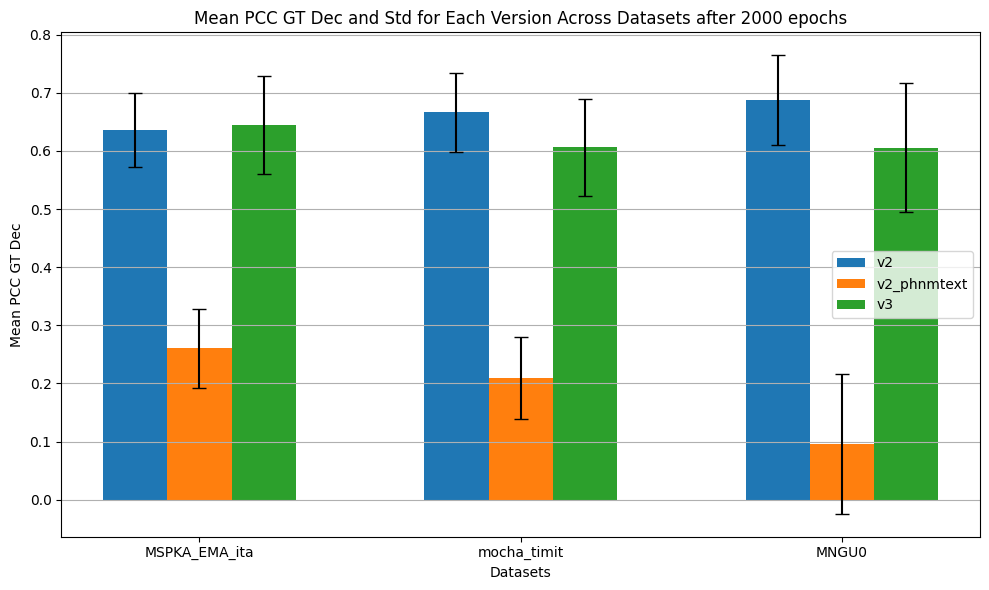

In [23]:
datasets = ["MSPKA_EMA_ita", "mocha_timit", "MNGU0"]
versions = ["v2", "v2_phnmtext", "v3"]
width = 0.2  # Bar width
x = np.arange(len(datasets))  # Dataset positions

# Prepare data for plotting
mean_scores = []
std_scores = []

for version in versions:
    means = []
    stds = []
    for dataset in datasets:
        version_df = pd.concat([get_specific_summary(dataset, speaker, version, "grad_2000") for speaker in dataset_2_speakers[dataset]])
        means.append(version_df["pcc_gt_dec"].mean())
        stds.append(version_df["pcc_gt_dec"].std())
    mean_scores.append(means)
    std_scores.append(stds)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for i, version in enumerate(versions):
    ax.bar(x + i * width, mean_scores[i], width, yerr=std_scores[i], label=version, capsize=5)

# Add labels and legend
ax.set_xlabel("Datasets")
ax.set_ylabel("Mean PCC GT Dec")
ax.set_title("Mean PCC GT Dec and Std for Each Version Across Datasets after 2000 epochs")
ax.set_xticks(x + width)
ax.set_xticklabels(datasets)
ax.legend()
ax.grid(axis="y")

plt.tight_layout()
plt.show()

# Phoneme level analysis

In [93]:
from text.phnms import get_phnms_from_phnm3
from text.converters import arpabet2ipa

lj_ipa_set = set(arpabet2ipa.values())

version = "v3"
ckpt_name = "grad_2000"

## MSPKA_EMA_ita

In [94]:
from utils_dataset.mspka import mspka2ipa

mspka_ipa_set = set(mspka2ipa.values())
extra_ipa_set = mspka_ipa_set - lj_ipa_set

dataset = "MSPKA_EMA_ita"
speakers = ["cnz", "olm", "lls"]

In [95]:
phnms_stats = {}

speaker = "cnz"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
cnz_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in cnz_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "lls"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
lls_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in lls_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "olm"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
olm_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in olm_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

phnms_scores = {phnm: (count, np.mean(values), np.std(values)) for phnm, (count, values) in phnms_stats.items() if count > 10}

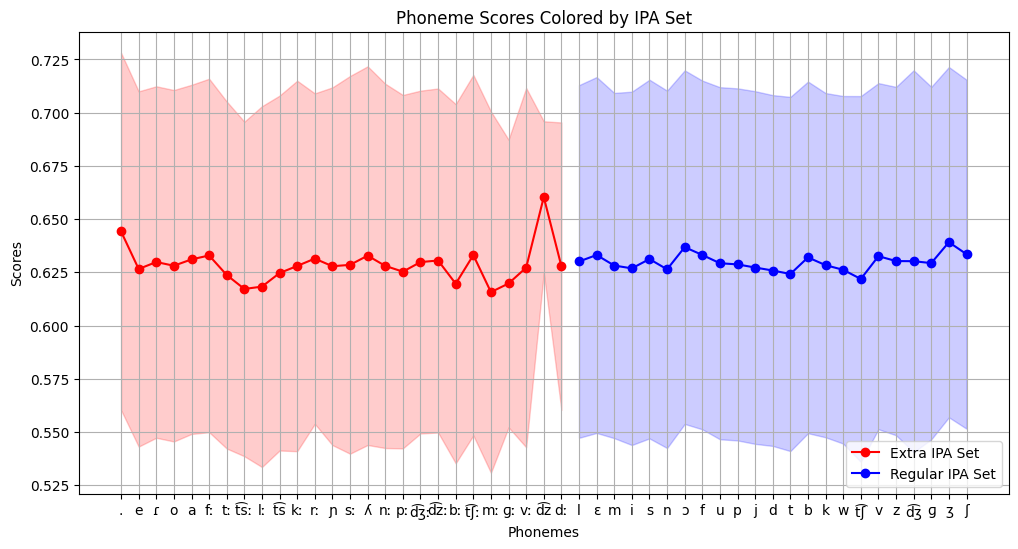

In [96]:
# Separate phonemes into two groups based on their presence in extra_ipa_set
extra_phnms = [phnm for phnm in phnms_scores.keys() if phnm in extra_ipa_set]
regular_phnms = [phnm for phnm in phnms_scores.keys() if phnm not in extra_ipa_set]

# Extract scores for each group
extra_scores = [phnms_scores[phnm][1] for phnm in extra_phnms]
extra_stds = [phnms_scores[phnm][2] for phnm in extra_phnms]
regular_scores = [phnms_scores[phnm][1] for phnm in regular_phnms]
regular_stds = [phnms_scores[phnm][2] for phnm in regular_phnms]

# Plot the phonemes with different colors
plt.figure(figsize=(12, 6))
plt.plot(extra_phnms, extra_scores, marker='o', color='red', label='Extra IPA Set')
plt.plot(regular_phnms, regular_scores, marker='o', color='blue', label='Regular IPA Set')
#plot stds
plt.fill_between(extra_phnms, np.array(extra_scores) - np.array(extra_stds),
                    np.array(extra_scores) + np.array(extra_stds), color='red', alpha=0.2)
plt.fill_between(regular_phnms, np.array(regular_scores) - np.array(regular_stds),
                    np.array(regular_scores) + np.array(regular_stds), color='blue', alpha=0.2)

# Add legend and labels
plt.legend()
plt.xlabel("Phonemes")
plt.ylabel("Scores")
plt.title("Phoneme Scores Colored by IPA Set")
plt.grid()
plt.show()

## MNGU0

In [97]:
from utils_dataset.mngu0 import mngu02ipa

mngu0_ipa_set = set(mngu02ipa.values())
extra_ipa_set = mngu0_ipa_set - lj_ipa_set

dataset = "MNGU0"
speakers = ["spk1"]

In [98]:
phnms_stats = {}

speaker = "s1"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
s1_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in s1_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])
        
phnms_scores = {phnm: (count, np.mean(values), np.std(values)) for phnm, (count, values) in phnms_stats.items() if count > 10}

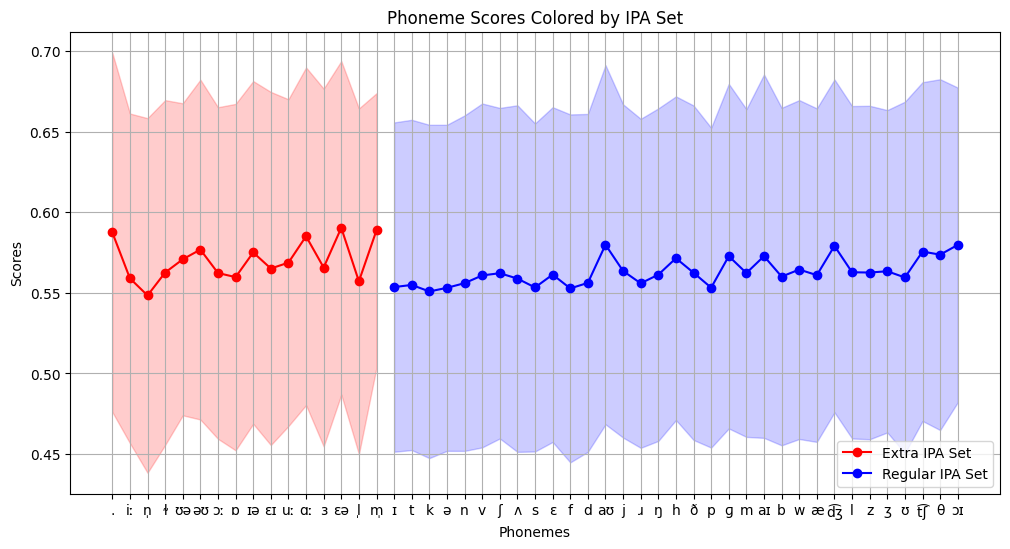

In [99]:
# Separate phonemes into two groups based on their presence in extra_ipa_set
extra_phnms = [phnm for phnm in phnms_scores.keys() if phnm in extra_ipa_set]
regular_phnms = [phnm for phnm in phnms_scores.keys() if phnm not in extra_ipa_set]

# Extract scores for each group
extra_scores = [phnms_scores[phnm][1] for phnm in extra_phnms]
extra_stds = [phnms_scores[phnm][2] for phnm in extra_phnms]
regular_scores = [phnms_scores[phnm][1] for phnm in regular_phnms]
regular_stds = [phnms_scores[phnm][2] for phnm in regular_phnms]

# Plot the phonemes with different colors
plt.figure(figsize=(12, 6))
plt.plot(extra_phnms, extra_scores, marker='o', color='red', label='Extra IPA Set')
plt.plot(regular_phnms, regular_scores, marker='o', color='blue', label='Regular IPA Set')
#plot stds
plt.fill_between(extra_phnms, np.array(extra_scores) - np.array(extra_stds),
                    np.array(extra_scores) + np.array(extra_stds), color='red', alpha=0.2)
plt.fill_between(regular_phnms, np.array(regular_scores) - np.array(regular_stds),
                    np.array(regular_scores) + np.array(regular_stds), color='blue', alpha=0.2)

# Add legend and labels
plt.legend()
plt.xlabel("Phonemes")
plt.ylabel("Scores")
plt.title("Phoneme Scores Colored by IPA Set")
plt.grid()
plt.show()

## mocha_timit

In [100]:
dataset = "mocha_timit"
speakers = ["fsew0", "faet0", "ffes0", "maps0", "mjjn0", "msak0"]

In [101]:
phnms_stats = {}

speaker = "fsew0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
fsew0_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in fsew0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "faet0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
faet0_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in faet0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "ffes0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
ffes0_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in ffes0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "maps0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
maps0_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in maps0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "mjjn0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
mjjn0_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in mjjn0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "msak0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
msak0_df = pd.read_csv(analysis_dir / f"quanti_art_comp_{version}_{ckpt_name}.csv")

for i, row in msak0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])
        
phnms_scores = {phnm: (count, np.mean(values), np.std(values)) for phnm, (count, values) in phnms_stats.items() if count > 10}

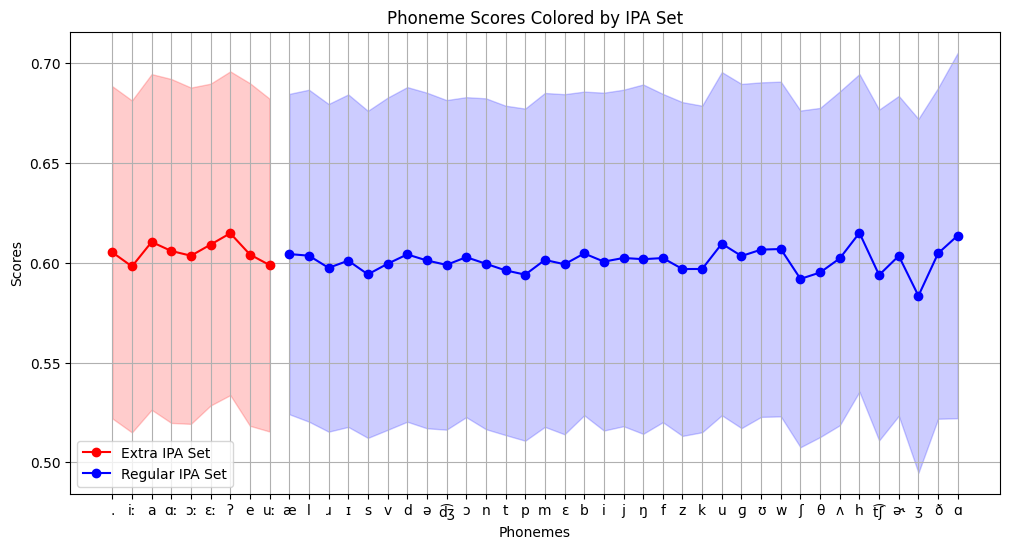

In [102]:
mocha_ipa_set = set(phnms_scores.keys())
extra_ipa_set = mocha_ipa_set - lj_ipa_set

# Separate phonemes into two groups based on their presence in extra_ipa_set
extra_phnms = [phnm for phnm in phnms_scores.keys() if phnm in extra_ipa_set]
regular_phnms = [phnm for phnm in phnms_scores.keys() if phnm not in extra_ipa_set]

# Extract scores for each group
extra_scores = [phnms_scores[phnm][1] for phnm in extra_phnms]
extra_stds = [phnms_scores[phnm][2] for phnm in extra_phnms]
regular_scores = [phnms_scores[phnm][1] for phnm in regular_phnms]
regular_stds = [phnms_scores[phnm][2] for phnm in regular_phnms]

# Plot the phonemes with different colors
plt.figure(figsize=(12, 6))
plt.plot(extra_phnms, extra_scores, marker='o', color='red', label='Extra IPA Set')
plt.plot(regular_phnms, regular_scores, marker='o', color='blue', label='Regular IPA Set')
#plot stds
plt.fill_between(extra_phnms, np.array(extra_scores) - np.array(extra_stds),
                    np.array(extra_scores) + np.array(extra_stds), color='red', alpha=0.2)
plt.fill_between(regular_phnms, np.array(regular_scores) - np.array(regular_stds),
                    np.array(regular_scores) + np.array(regular_stds), color='blue', alpha=0.2)

# Add legend and labels
plt.legend()
plt.xlabel("Phonemes")
plt.ylabel("Scores")
plt.title("Phoneme Scores Colored by IPA Set")
plt.grid()
plt.show()